In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
marketing_data=pd.read_csv(r'https://raw.githubusercontent.com/kiryouri/marketing_data_project/main/marketing_data.csv')

In [3]:
marketing_data.isna().sum()
#в колонке 'Income' 24 n/a

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
 Income                24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Complain                0
Country                 0
dtype: int64

In [4]:
#заметно что в тайтлах есть лишние пробелы, используем strip
marketing_data=marketing_data.rename(columns=lambda strcols: strcols.strip())
marketing_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4   Income               2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [5]:
#Income-object, нужно конвертировать в float, перед этим надо будет убрать запятую и знак $
marketing_data['Income'] = marketing_data['Income'].str.replace('$', '')
marketing_data['Income'] = marketing_data['Income'].str.replace(',', '').astype('float')

In [6]:
marketing_data.Income=marketing_data.Income.fillna(marketing_data.Income.median()) 

<Figure size 864x432 with 0 Axes>

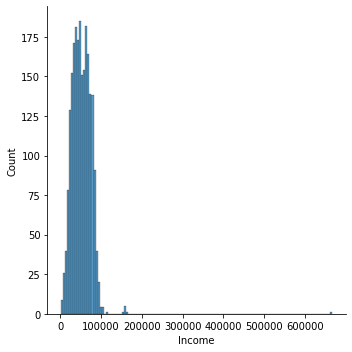

In [7]:
plt.figure(figsize=(12,6))
sns.displot(x=marketing_data.Income)

# доход +- однороден, есть немного выбросов около 150к и после 650, нагляднее будет видно на боксплоте

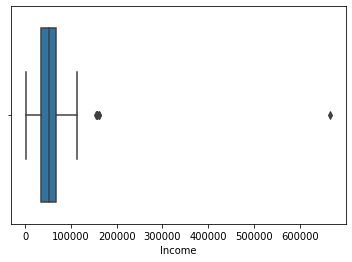

In [8]:
ax = sns.boxplot(x='Income', data = marketing_data)

In [9]:
cols = marketing_data[['Year_Birth','Income','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']] #

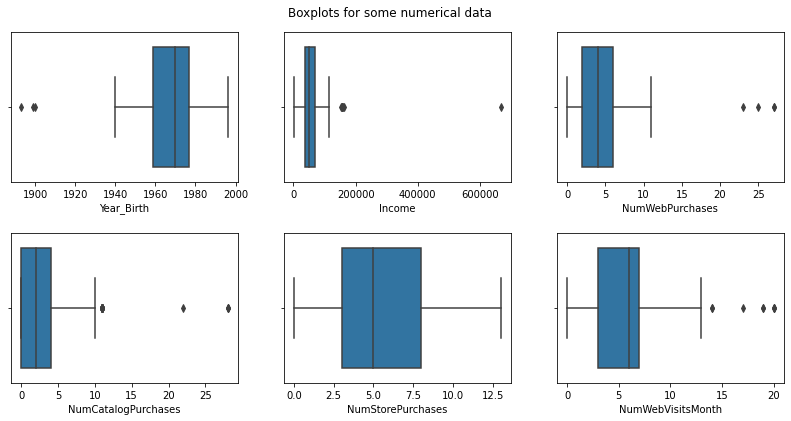

In [10]:
#построим боксплоты для количества покупок/годов рождений,содержание покупок нас пока не интересует
fig, axes = plt.subplots(2, 3, sharey=True, figsize=(12,6))
fig.tight_layout(pad = 3.0)                            #больше расстояния между графиками
axes=axes.flatten()                                  #для итерации по осям их нужно сплющить
fig.suptitle('Boxplots for some numerical data')  

for ax, x in zip(axes, list(cols)):                 #т.к. итерация нужна по нескольким спискам одновременно
    sns.boxplot(ax = ax, x = x, data = marketing_data)

In [11]:
#На графиках заметны выбросы в годах рождения (скорее всего ошибка ввода), доходах(лишний ноль?), в остальных колонках их можно объяснить постоянностью некоторых покупателей

In [12]:
#По заданию нужно определить ("What factors are significantly related to the number of store purchases"), логически наибольший вклад должен внести доход, больше денег-больше покупок, для подтверждения этой гипотезы воспользуемся простой линейной регрессией

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
x=np.array(marketing_data['Income']).reshape((-1, 1))
y=np.array(marketing_data['NumStorePurchases'])
model = LinearRegression()

In [15]:
model.fit(x, y)
r_squared = model.score(x, y)
print('coefficient of determination:', r_squared)
print('intercept:', model.intercept_)
print('slope:', model.coef_)

coefficient of determination: 0.2773073348965519
intercept: 2.218441152487357
slope: [6.83743462e-05]


In [16]:
#действительно, почти треть

In [17]:
#"Does US fare significantly better than the Rest of the World in terms of total purchases?" - для ответа на этот вопрос нужно будет создать новую колонку с суммой всех покупок

In [18]:
marketing_data['TotalPurchases']=(marketing_data[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']].sum(axis=1))

In [19]:
median=marketing_data['TotalPurchases'].median()
mean=marketing_data['TotalPurchases'].mean() #среднее арифметическое и медиана +- равны, значит сильных выбросов быть не должно, удостоверимся с помощью дистплота

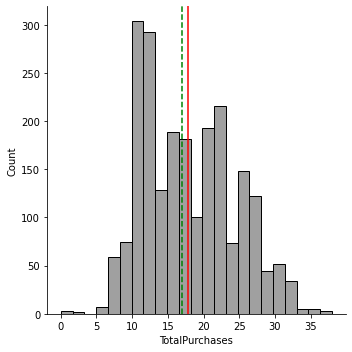

In [20]:
sns.displot(x=marketing_data['TotalPurchases'],color='grey')
plt.axvline(median, color='g', linestyle='--')
plt.axvline(mean, color='r', linestyle='-')

In [21]:
marketing_data.groupby('Country',as_index=False).agg({'TotalPurchases':'sum'}).sort_values(by='TotalPurchases', ascending=False).reset_index(drop=True) 
#По количеству покупок US не в топе 

,Country,TotalPurchases
0,SP,19403
1,SA,6084
2,CA,4874
3,AUS,2779
4,IND,2548
5,GER,2151
6,US,2083
7,ME,70


In [22]:
#аналогично проверим по количеству купленных товаров
amount_columns=list(marketing_data.columns[marketing_data.columns.str.startswith('Mnt')])

In [23]:
marketing_data['TotalAmount']=marketing_data[amount_columns].sum(axis=1)

In [24]:
marketing_data['TotalAmount']

0       1190
1        577
2        251
3         11
4         91
        ... 
2235     689
2236      55
2237     309
2238    1383
2239    1078
Name: TotalAmount, Length: 2240, dtype: int64

In [25]:
marketing_data.groupby('Country',as_index=False).agg({'TotalAmount':'sum'}) \
.sort_values(by='TotalAmount', ascending=False).reset_index(drop=True) 
#тут тоже не в топе, основная масса покупателей из Испании

,Country,TotalAmount
0,SP,662220
1,SA,211071
2,CA,168532
3,AUS,89763
4,IND,79485
5,GER,74913
6,US,67882
7,ME,3122


In [26]:
#построим графики для наглядности
df_tp=marketing_data.groupby('Country',as_index=False).agg({'TotalPurchases':'sum'}).sort_values(by='TotalPurchases', ascending=False).reset_index(drop=True)
df_ta=marketing_data.groupby('Country',as_index=False).agg({'TotalAmount':'sum'}).sort_values(by='TotalAmount', ascending=False).reset_index(drop=True)

In [27]:
#df_ta_tp_merged=df_tp.merge(df_ta,on='Country')

<AxesSubplot:xlabel='Country'>

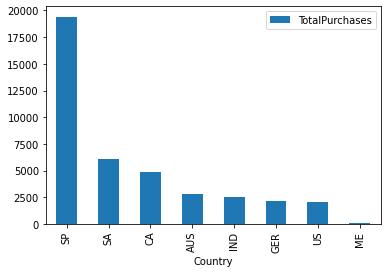

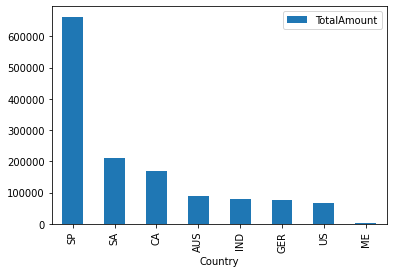

In [28]:
df_tp.plot(kind='bar', x='Country')
df_ta.plot(kind='bar', x='Country')

<AxesSubplot:xlabel='MntGoldProds'>

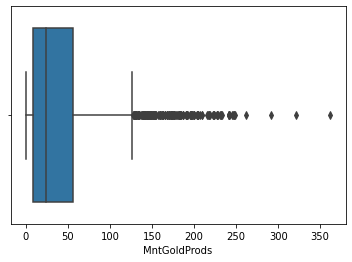

In [29]:
#"Your supervisor insists that people who buy gold are more conservative."
#"Therefore, people who spent an above average amount on gold in the last 2 years would have more in store purchases. Justify or refute this statement using an appropriate statistical test"
#Посмотрим на выбросы
sns.boxplot(x='MntGoldProds', data=marketing_data)

In [30]:
import scipy.stats
scipy.stats.spearmanr(marketing_data['MntGoldProds'], marketing_data['TotalPurchases']) #Вычислим коэф ранговой корреляции Спирмена

SpearmanrResult(correlation=0.615299973352091, pvalue=1.6773826039080156e-233)

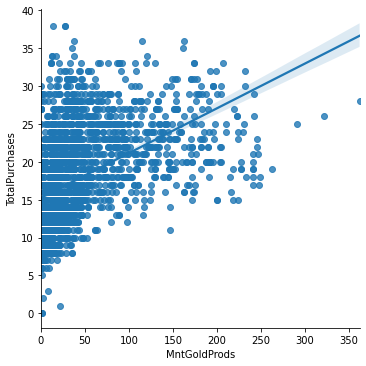

In [31]:
#Есть статистически значимая положительная корреляция
sns.lmplot(x='MntGoldProds', y='TotalPurchases', data = marketing_data)

<AxesSubplot:>

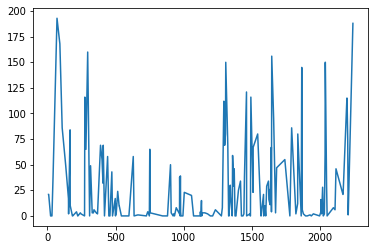

In [32]:
#Fish has Omega 3 fatty acids which are good for the brain. Accordingly, do "Married PhD candidates" have a significant relation with amount spent on fish?

marketing_data[['Marital_Status','Education']]
marketing_data.Education.unique()

#Отфильтруем подходящих под "Married PhD candidates" покупателей
married_and_phd_fish=marketing_data.query('Marital_Status=="Married" and Education=="PhD"')['MntFishProducts']
married_and_not_phd=marketing_data.query('Marital_Status!="Married" and Education!="PhD"')['MntFishProducts']

#в среднем женатые и Phd покупают меньше рыбы, стат значимость проверим далее

from scipy import stats
stats.shapiro(married_and_phd_fish)

married_and_phd_fish.plot()
#H0 - в генеральной совокупности женатые и phd покупают столько же рыбопродуктов сколько и не таковые

In [33]:
#Дабы оценить различия в двух независимых группах воспользуемся U-критерием Манна — Уитни
u, p_value = stats.mannwhitneyu(married_and_phd_fish, married_and_not_phd) 
print ("two-sample wilcoxon-test", p_value)

two-sample wilcoxon-test 8.289165542244821e-07


In [34]:
#Можно отклонить нулевую гипотезу, статистически значимое отличие действительно присутствует


In [35]:
#to be continued..